In [1]:
#LECTURA DE LAS INSTANCIAS

nombre_archivo = str(input('Ingrese el número de la instancia: '))+'.txt'
archivo = open(nombre_archivo,'r')
info = archivo.read()
archivo.close()

L = info.split()
V = int(L[0])
I = int(L[1])
C = int(L[2])
P = int(L[3])

id_instalacion = []
instalacion_xx = []
instalacion_yy = []
id_cliente = []
cliente_x = []
cliente_y = []
#recolectando la informacion de las instalaciones
for i in range(4,int(I)*3+4+1,3):
    id_instalacion.append(int(L[i]))
    instalacion_xx.append(float(L[i+1]))
    instalacion_yy.append(float(L[i+2]))
    
#recolectando la informacion de los clientes
for i in range(int(I)*3+4+3,int(C)*3+1+int(I)*3+4+1,3):
    id_cliente.append(int(L[i]))
    cliente_x.append(float(L[i+1]))
    cliente_y.append(float(L[i+2]))
    
#recolectando las capacidades de abastecimiento de las instalaciones
aux=int(int(C)*3+1+int(I)*3+4+1+1)
capacidad = []
completado = 0
while completado<2:
    abastece=int(L[aux+1])
    sub=[]
    for i in range(2,abastece+2):
        sub.append(L[aux+i])
    capacidad.append(sub)
    aux= aux+i+1
    completado=+1
    if aux==len(L):
        break
# p es una lista donde está la cantidad de clientes que abastece cada instalación        
p = [len(i) for i in capacidad]
B = []
for i in range(I):
    for elem in capacidad[i]:
        z = (int(elem),i+1)
        B.append(z)       
p.insert(0,0)

Ingrese el número de la instancia: 16


In [2]:
#importando las librerias
import matplotlib
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import numpy as np

In [3]:
#parametros

instalaciones = [i for i in range(1,I+1)]
clientes = [i for i in range(I+1,V)]
deposito = [0]
deposito_x = [instalacion_xx[0]]
deposito_y = [instalacion_yy[0]]
instalacion_x = [instalacion_xx[i] for i in range(1,len(instalacion_xx))]
instalacion_y = [instalacion_yy[i] for i in range(1,len(instalacion_yy))]
arcos = [(i,j) for i in id_instalacion for j in id_instalacion if i!=j]
distancia = {(i,j): np.hypot(instalacion_xx[i]-instalacion_xx[j], instalacion_yy[i]-instalacion_yy[j]) for i,j in arcos }
ene = len(instalaciones)

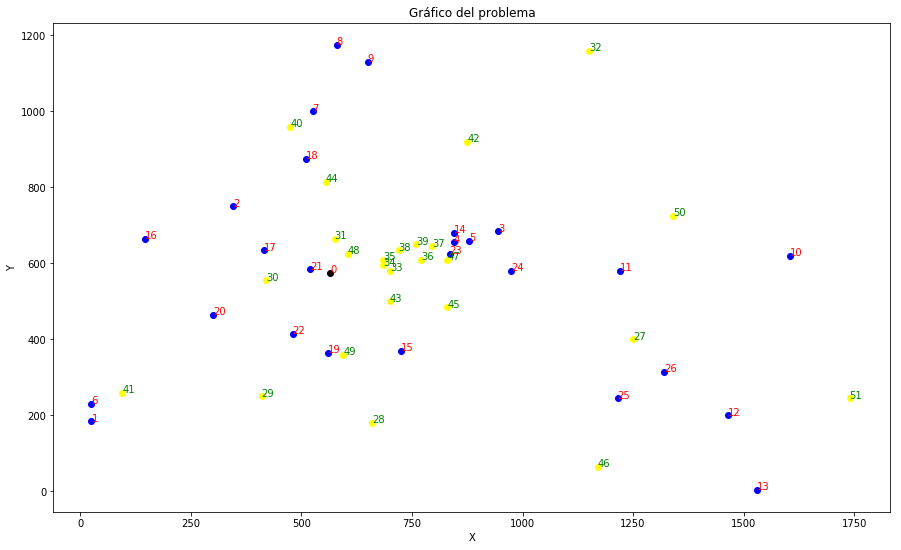

In [4]:
x = instalacion_x
y = instalacion_y


plt.figure(figsize=(15,9))

#graficando las instalaciones
plt.scatter(x,y,color='blue')
s=[]
for n in range(0,len(instalacion_x)):
    s_temp=[]
    s_temp.append("%.1f" %instalacion_x[n])
    s_temp.append("%.1f" %instalacion_y[n])
    s.append(s_temp)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gráfico del problema")

for n in range(0,len(instalacion_x)):
    plt.annotate(str(n+1), xy=(instalacion_x[n],instalacion_y[n] ), xytext=(instalacion_x[n],instalacion_y[n]+0.5), color='red')

    
#graficando los clientes    
f = []
a = cliente_x
b = cliente_y
plt.scatter(a,b,color='yellow')
for n in range(len(cliente_x)):
    f_temp=[]
    f_temp.append("%.1f" %cliente_x[n])
    f_temp.append("%.1f" %cliente_y[n])
    f.append(f_temp)
    
for n in range(I+1,I+1+C):
    plt.annotate(str(n), xy=(cliente_x[n-(I+1)],cliente_y[n-(I+1)] ), xytext=(cliente_x[n-(I+1)],cliente_y[n-(I+1)]+0.5), color='green')

#Graficando el depósito

plt.scatter(x=deposito_x,y=deposito_y,color='black')
dep_temp=["%.1f" %deposito_x[0],"%.1f" %deposito_y[0]]
plt.annotate(str(0), xy=(deposito_x[0],deposito_y[0] ), xytext=(deposito_x[0],deposito_y[0]+0.5), color='red')

#COLORES: Negro: Depósito, Azul: Instalaciones, Amarillo: Clientes

plt.show()

In [5]:
#Modelo

mdl = Model('tarea')

In [6]:
#Variables de decision
x = mdl.binary_var_dict(arcos, name='x')
y = mdl.binary_var_dict(B, name='y')
u = mdl.continuous_var_dict(id_instalacion, name='u')

In [7]:
#Funcion objetivo
mdl.minimize(mdl.sum(distancia[i]*x[i] for i in arcos))

In [8]:
#Restricciones

mdl.add_constraint(mdl.sum(x[(0,j)] for j in instalaciones)==1) #Res1
mdl.add_constraint(mdl.sum(x[(i,0)] for i in instalaciones)==1) #Res2

for i,j in arcos: #Res3
    if i!=0:
        mdl.add_constraint(u[i]-u[j] +1 -ene*(1-x[(i,j)])<=0)
        
    
for c in id_instalacion: #Res 4
    mdl.add_constraint((mdl.sum(x[c,j] for j in id_instalacion if j!=c)) ==(mdl.sum(x[i,c] for i in id_instalacion if i !=c)))

    
for i,j in arcos: #Res 5
    mdl.add_constraint(x[i,j]+x[j,i]<=1)
    
    
for c in range(I+1,V): #Res 6
    mdl.add_constraint(mdl.sum(y[i,j] for i,j in B if i==c)<=1)
    

mdl.add_constraint(mdl.sum(y[i,j] for i,j in B)>=P) #Res 7

for i in instalaciones: #Res 8 
    mdl.add_constraint((p[i]*mdl.sum(x[a,b] for a,b in arcos if a==i))>=(mdl.sum(y[c,d] for c,d in B if d==i)))


In [9]:
#Se crea la variable solucion, donde se almacena (valga la redundancia), la solución del problema.
solucion = mdl.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 386 rows and 32 columns.
MIP Presolve modified 52 coefficients.
Reduced MIP has 1072 rows, 841 columns, and 5007 nonzeros.
Reduced MIP has 815 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.17 ticks)
Probing time = 0.00 sec. (1.21 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 6 columns.
MIP Presolve modified 261 coefficients.
Reduced MIP has 1072 rows, 835 columns, and 5001 nonzeros.
Reduced MIP has 809 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (3.28 ticks)
Probing time = 0.00 sec. (1.18 ticks)
Clique table members: 371.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 6 threads.
Root relaxati

 115714 65287     2679.2137    24     2958.7791     2559.9335   856464   13.48%
 121260 68930     2746.3880    25     2958.7791     2565.0431   907651   13.31%
 126530 72384     2950.5741    12     2958.7791     2569.8344   958640   13.15%
 131753 75684     2711.4794     9     2958.7791     2574.8127  1010767   12.98%
 136630 78955     2875.1015    30     2958.7791     2579.7869  1066483   12.81%
 142017 82170     2689.1932     3     2958.7791     2584.2852  1124040   12.66%
 147011 85323     2713.9120     4     2958.7791     2589.2592  1177971   12.49%
 151632 87649     2948.7513    14     2958.7791     2592.5511  1225181   12.38%
Elapsed time = 27.02 sec. (23840.38 ticks, tree = 80.69 MB, solutions = 6)
 156183 90232        cutoff           2958.7791     2597.0704  1281544   12.22%
 160706 92425     2814.3697    30     2958.7791     2600.8601  1332342   12.10%
 164695 94204     2834.3268    17     2958.7791     2604.4905  1377720   11.97%
 169148 96209        cutoff           2958.77


Cover cuts applied:  2095
Implied bound cuts applied:  29
Flow cuts applied:  20
Mixed integer rounding cuts applied:  350
Zero-half cuts applied:  34
Lift and project cuts applied:  59
Gomory fractional cuts applied:  7

Root node processing (before b&c):
  Real time             =    0.48 sec. (204.58 ticks)
Parallel b&c, 6 threads:
  Real time             =  190.22 sec. (156486.08 ticks)
  Sync time (average)   =   12.55 sec.
  Wait time (average)   =    0.24 sec.
                          ------------
Total (root+branch&cut) =  190.70 sec. (156690.66 ticks)


In [10]:
#Se obtiene el status de la solución, OPTIMAL_SOLUTION cuando la solución es óptima, INFEASIBLE para cuando es infactible.

mdl.get_solve_status()

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [11]:
#El modelo planteado es:

print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: tarea

Minimize
 obj: 666.108099335236 x_0_1 + 281.113855937412 x_0_2 + 395.600808897050 x_0_3
      + 291.204395571221 x_0_4 + 326.266762021509 x_0_5 + 640.800280898815 x_0_6
      + 426.878202769830 x_0_7 + 600.187470712277 x_0_8 + 561.471281545192 x_0_9
      + 1040.973102438291 x_0_10 + 655.019083691460 x_0_11 + 975 x_0_12
      + 1120.769824718707 x_0_13 + 299.040131086114 x_0_14
      + 260.048072478917 x_0_15 + 429.534631898291 x_0_16
      + 161.554944214035 x_0_17 + 305 x_0_18 + 210.059515376000 x_0_19
      + 286.923334708071 x_0_20 + 46.097722286464 x_0_21
      + 181.176709319934 x_0_22 + 274.590604354920 x_0_23
      + 410.030486671418 x_0_24 + 728.971878744304 x_0_25
      + 798.514245333169 x_0_26 + 666.108099335236 x_1_0
      + 649.326574229024 x_1_2 + 1047.091209016674 x_1_3
      + 945.145491445629 x_1_4 + 978.084863393765 x_1_5 + 45 x_1_6
      + 956.151138680491 x_1_7 + 1134.955946281617

In [12]:
#Se imprime la solución óptima, la función objetivo y las variables previamente definidas.
solucion.display()

solution for: tarea
objective: 2958.779
x_0_3 = 1
x_2_0 = 1
x_3_10 = 1
x_10_22 = 1
x_20_2 = 1
x_22_20 = 1
y_44_2 = 1
y_31_2 = 1
y_40_2 = 1
y_48_2 = 1
y_37_3 = 1
y_39_3 = 1
y_36_3 = 1
y_38_3 = 1
y_42_3 = 1
y_33_3 = 1
y_35_3 = 1
y_50_10 = 1
y_51_10 = 1
y_27_10 = 1
y_46_10 = 1
y_32_10 = 1
y_47_10 = 1
y_45_10 = 1
y_41_20 = 1
y_49_20 = 1
y_30_22 = 1
y_29_22 = 1
y_43_22 = 1
y_34_22 = 1
y_28_22 = 1
u_0 = 26.000
u_2 = 25.000
u_10 = 1.000
u_11 = 25.000
u_20 = 3.000
u_22 = 2.000


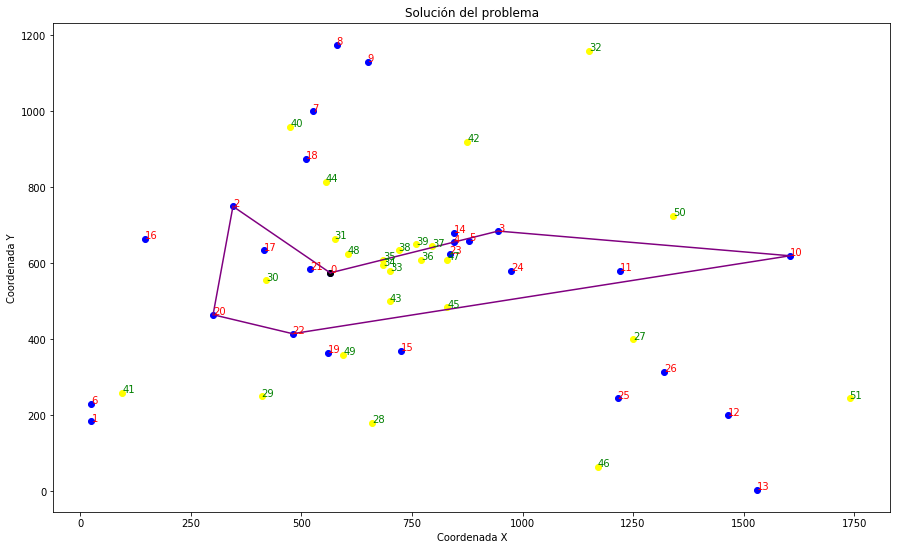

In [13]:
#Se grafica la ruta obtenida previamente

arcos_solucion = [i for i in arcos if x[i].solution_value>0.9]
plt.figure(figsize=(15,9))
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Solución del problema')

plt.scatter(x=instalacion_xx,y=instalacion_yy,color='blue',zorder=1)
for i,j in arcos_solucion:
    plt.plot([instalacion_xx[i],instalacion_xx[j]],[instalacion_yy[i],instalacion_yy[j]],color='purple',zorder=1)
    
for n in range(0,len(instalacion_x)):
    plt.annotate(str(n+1), xy=(instalacion_x[n],instalacion_y[n] ), xytext=(instalacion_x[n],instalacion_y[n]+0.5), color='red')


a = cliente_x
b = cliente_y
plt.scatter(a,b,color='yellow')
for n in range(len(cliente_x)):
    f_temp=[]
    f_temp.append("%.1f" %cliente_x[n])
    f_temp.append("%.1f" %cliente_y[n])
    f.append(f_temp)
    
for n in range(I+1,I+1+C):
    plt.annotate(str(n), xy=(cliente_x[n-(I+1)],cliente_y[n-(I+1)] ), xytext=(cliente_x[n-(I+1)],cliente_y[n-(I+1)]+0.5), color='green')

plt.scatter(x=deposito_x,y=deposito_y,color='black')
dep_temp=["%.1f" %deposito_x[0],"%.1f" %deposito_y[0]]
plt.annotate(str(0), xy=(deposito_x[0],deposito_y[0] ), xytext=(deposito_x[0],deposito_y[0]+0.5), color='red')

#COLORES: Negro: Depósito, Azul: Instalaciones, Amarillo: Clientes    

plt.show()